# Multivariate analysis 
## Research question: Are STAT1.1, SAA1 and FGL1 protein abundances associated with COVID-19 severity (mild/moderate/severe/critical) after accounting for sex?

-	Independent variables (predictors): STAT1.1, SAA1, FGL1 and sex  
-	Dependent variable (outcome): COVID-19 severity level (mild, moderate, severe, critical)

H₀: After adjusting for sex, none of the proteins (STAT1.1, SAA1, FGL1) are associated with COVID-19 severity.

H₁: After adjusting for sex, at least one of the proteins (STAT1.1, SAA1, FGL1) is associated with COVID-19 severity.



In [10]:
# ================================================================
# 0. IMPORT LIBRARIES
# ================================================================
import pandas as pd                     
import numpy as np                     

# Visualization
import matplotlib.pyplot as plt        
import seaborn as sns                  

# Scaling & preprocessing
from sklearn.preprocessing import StandardScaler  

# Statistical modelling
import statsmodels.api as sm            
from statsmodels.tools import add_constant  

In [11]:
# ================================================================
# 1. LOAD THE DATASET AND HANDLE MISSING VALUES
# ================================================================

# Define all the "missing-value" indicators
missing_values = ["", "unknown", "Unknown"]

# Load combined dataset and automatically convert missing markers to NaN
combined_dataset_df = pd.read_csv("combined_dataset.csv", na_values=missing_values)

# Count missing values per column
missing_count = combined_dataset_df.isna().sum()
missing_count = missing_count[missing_count > 0]
print("Missing values per column:")
print(missing_count)

# Save version of dataset with explicit 'NaN' in CSV file
combined_dataset_df.to_csv("NaN-missing values.csv", index=False, na_rep="NaN")

Missing values per column:
ihd                              24
smoking                           8
cause_eskd                       51
WHO_severity                     53
fatal_disease                    53
radiology_evidence_covid         53
time_from_first_symptoms         82
time_from_first_positive_swab    53
dtype: int64


In [12]:
# ================================================================
# 2. ANALYSIS OF PROTEIN ABUNDANCE DIFFERENCES BETWEEN COVID+ AND COVID–
# ================================================================

# -----------------------------
# 2.1 Select only protein columns
# -----------------------------

# Create a copy of the dataset, keeping NaNs
NaN_combined_dataset_df = combined_dataset_df.copy()

# Get all column names
all_cols = NaN_combined_dataset_df.columns.tolist()

# Find the index of 'individual_id'
start_idx = all_cols.index("individual_id")

# Exclude first column (index 0) and all columns from 'individual_id' to the end
protein_cols = all_cols[1:start_idx] 

In [13]:
# -----------------------------
# 2.2 Compute MEAN PER PATIENT
# -----------------------------
NaN_combined_dataset_df_patient = ( 
    NaN_combined_dataset_df.groupby(["individual_id", "case_control"])[protein_cols]
      .mean().reset_index())
NaN_combined_dataset_df_patient.head()

,individual_id,case_control,CRYBB2,RAF1,ZNF41,ELK1,GUCA1A,BECN1,OCRL,SPDEF,...,YIPF6,NPW,LRRC25.1,LRRC24,EMILIN3.1,ZNF264,ATP4B,DUT,UBXN4.1,IRF6
0,C101,NEGATIVE,337.900000,302.300000,227.800000,1476.100000,342.900000,238.400000,1900.500000,557.100000,...,411.6,8456.700000,259.300000,393.1,232.600000,459.6,883.800000,1952.300000,10867.300000,1053.000000
1,C101,POSITIVE,308.042857,735.157143,144.514286,724.442857,272.528571,177.485714,1817.814286,615.785714,...,314.0,1306.442857,245.742857,252.7,269.457143,551.8,1276.228571,12959.457143,56871.457143,4009.542857
2,C103,NEGATIVE,330.300000,319.500000,199.900000,859.500000,357.500000,234.500000,2662.600000,516.100000,...,366.2,9455.400000,230.200000,371.0,212.400000,467.6,984.900000,2328.400000,13787.700000,897.100000
3,C104,NEGATIVE,312.300000,324.200000,199.800000,711.200000,396.200000,233.500000,2272.700000,524.700000,...,372.2,6597.200000,253.700000,342.1,198.900000,453.1,851.900000,2729.700000,21386.400000,1140.400000
4,C106,NEGATIVE,334.400000,256.000000,199.900000,760.800000,400.400000,336.500000,3396.000000,594.800000,...,409.8,2176.700000,259.600000,359.8,285.700000,515.6,837.100000,1952.600000,10962.200000,858.200000


In [14]:
# -----------------------------
# 2.3 Compute MEAN PER COVID GROUP
# -----------------------------
group_means = NaN_combined_dataset_df_patient.groupby("case_control")[protein_cols].mean()
group_means

,CRYBB2,RAF1,ZNF41,ELK1,GUCA1A,BECN1,OCRL,SPDEF,SNAI2,KCNAB2,...,YIPF6,NPW,LRRC25.1,LRRC24,EMILIN3.1,ZNF264,ATP4B,DUT,UBXN4.1,IRF6
case_control,,,,,,,,,,,,,,,,,,,,,
NEGATIVE,341.279245,370.826415,214.860377,791.586792,348.239623,236.484906,1997.698113,536.758491,547.741509,409.486792,...,371.039623,6399.479245,258.013208,364.788679,356.141509,488.684906,907.133962,3396.333962,21307.313208,1431.15283
POSITIVE,373.853633,488.612540,186.724832,706.313880,329.290653,221.908501,2121.024092,550.259303,530.641490,403.441790,...,352.763457,2887.482152,271.065732,318.489815,383.561120,560.753148,1315.204480,8016.387108,34614.408219,2255.04246


In [15]:
# -----------------------------
# 2.4 Compute DIFFERENCE (COVID+ – COVID–)
# -----------------------------
diff = group_means.loc["POSITIVE"] - group_means.loc["NEGATIVE"]
diff

CRYBB2        32.574388
RAF1         117.786125
ZNF41        -28.135545
ELK1         -85.272912
GUCA1A       -18.948970
               ...     
ZNF264        72.068242
ATP4B        408.070517
DUT         4620.053145
UBXN4.1    13307.095011
IRF6         823.889630
Length: 7240, dtype: float64

In [16]:
# -----------------------------
# 2.5 Create ranked results table
# -----------------------------

# Create a DataFrame with protein, means, and differences
diff_df = pd.DataFrame({
    "protein": diff.index,
    "mean_covid_positive": group_means.loc["POSITIVE"],
    "mean_covid_negative": group_means.loc["NEGATIVE"],
    "difference": diff.values,
    "abs_difference": np.abs(diff.values)
})

# Sort by largest absolute difference
diff_df = diff_df.sort_values(by="abs_difference", ascending=False)

# Display top 10 proteins
print(diff_df.head(10))

         protein  mean_covid_positive  mean_covid_negative    difference  \
STAT1.1  STAT1.1        102445.296702         35154.290566  67291.006136   
SAA1        SAA1         73805.356693         14620.724528  59184.632165   
FGL1        FGL1         99705.269012         49070.116981  50635.152031   
LAP3        LAP3         81274.778157         37934.850943  43339.927214   
ME2          ME2        106583.407099         68198.845283  38384.561816   
IGFBP6    IGFBP6        183029.683598        219247.666038 -36217.982440   
PTN          PTN         91214.957734         56104.424528  35110.533205   
MDH2        MDH2        116667.498474         86021.005660  30646.492814   
CRP          CRP         79061.730212         48809.381132  30252.349080   
NMI          NMI         47233.721711         17502.533962  29731.187748   

         abs_difference  
STAT1.1    67291.006136  
SAA1       59184.632165  
FGL1       50635.152031  
LAP3       43339.927214  
ME2        38384.561816  
IGFBP6 

In [17]:
# -----------------------------
# 2.6 Save results
# -----------------------------
diff_df.to_csv("multivariate_protein_abundance_differences_covid_pos_vs_neg.csv", index=False)

In [18]:
# ================================================================
# 3. CREATE MULTIVARIATE DATASET WITH CHOSEN PROTEINS AND METADATA
# ================================================================
# We chose the first 3 proteins based on highest abs difference
multivariate_df = NaN_combined_dataset_df[['individual_id', 'STAT1.1', 'SAA1', 'FGL1', 'case_control', 'WHO_severity', 'sex']]
multivariate_df.to_csv('multivariate_dataset.csv', index=False, na_rep='NaN')

# Load the multivariate dataset
df = pd.read_csv("multivariate_dataset.csv")

In [19]:
# ================================================================
# 4. CONVERT DATA TYPES FOR MODELING
# ================================================================

# ---------------------------------------------------------------
# 4.1 Convert severity to ordinal numeric scale and fill missing values with 0
# ---------------------------------------------------------------
df["severity_num"] = df["WHO_severity"].map({"mild": 1, "moderate": 2, "severe": 3, "critical": 4}).fillna(0)

# ---------------------------------------------------------------
# 4.2 Convert case_control to binary (POSITIVE=1, NEGATIVE=0)
# ---------------------------------------------------------------
df["covid_status"] = df["case_control"].map({"NEGATIVE": 0, "POSITIVE": 1})

# ---------------------------------------------------------------
# 4.3 Convert sex to binary (male=1, female=0)
# ---------------------------------------------------------------
df["sex_binary"] = df["sex"].map({"M": 1, "F": 0})

# -----------------------------
# 4.4 Preview the converted columns
# -----------------------------
print("\nPreview after type conversions:")
print(df[["STAT1.1", "SAA1", "FGL1", "covid_status", "severity_num", "sex_binary"]].head())


Preview after type conversions:
    STAT1.1     SAA1     FGL1  covid_status  severity_num  sex_binary
0   16370.9   3710.4   8092.9             0           0.0           1
1  116410.0  66658.6  59318.3             1           3.0           1
2  102239.6  29836.3  40057.1             1           3.0           1
3  151742.6  28990.6  72371.2             1           3.0           1
4  237416.3  22768.6  74505.4             1           3.0           1


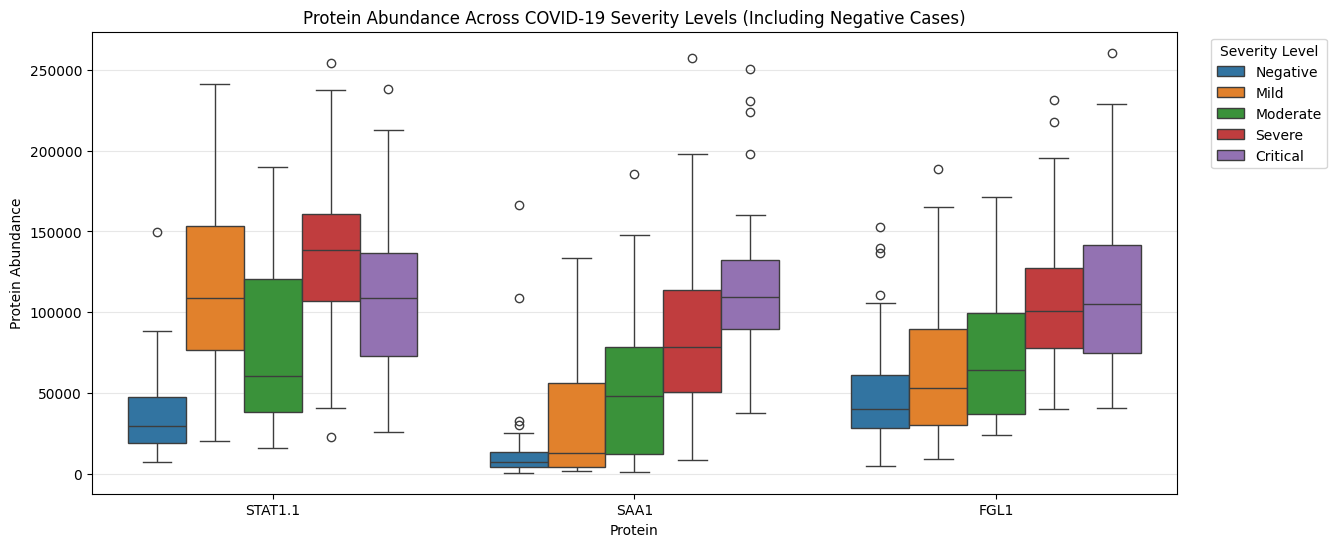

In [20]:
# ================================================================ 
# 5. BOXPLOTS BY SEVERITY TO DETECT OUTLIERS 
# ================================================================ 

# ------------------------------------------------------------
# 5.1 Create a clean severity label including NEGATIVE
# ------------------------------------------------------------
severity_labels = {0: "Negative", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Critical"}
df["severity_label"] = df["severity_num"].map(severity_labels)

# Ensure proper ordering (otherwise the severities would be ranked alphabetically and not negative to critical)
ordered_levels = ["Negative", "Mild", "Moderate", "Severe", "Critical"]
df["severity_label"] = pd.Categorical(df["severity_label"], categories=ordered_levels, ordered=True)

# ------------------------------------------------------------
# 5.2 Melt dataset for seaborn
# ------------------------------------------------------------
melt_df = df.melt(
    id_vars="severity_label",
    value_vars=["STAT1.1", "SAA1", "FGL1"],
    var_name="protein",
    value_name="abundance"
)

# ------------------------------------------------------------
# 5.3 PLOT THE BOXPLOTS
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=melt_df,
    x="protein",
    y="abundance",
    hue="severity_label",
    palette="tab10" # high contrast 
)

plt.title("Protein Abundance Across COVID-19 Severity Levels (Including Negative Cases)")
plt.ylabel("Protein Abundance")
plt.xlabel("Protein")
plt.grid(axis="y", alpha=0.3)

plt.legend(title="Severity Level", bbox_to_anchor=(1.025, 1), loc="upper left")
plt.show()

In [21]:
# ------------------------------------------------------------
# 5.4 OUTLIER DETECTION
# ------------------------------------------------------------

proteins = ["STAT1.1", "SAA1", "FGL1"]

# List to store detailed outlier info
outlier_list = []

# Loop through each severity level
for sev in df["severity_label"].unique():
    sub = df[df["severity_label"] == sev]

    #Loops through each protein in the proteins list
    for protein in proteins:
        Q1 = sub[protein].quantile(0.25)
        Q3 = sub[protein].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = sub[(sub[protein] < lower) | (sub[protein] > upper)]

        for row_index, row in outliers.iterrows():
            outlier_list.append({
                "individual_id": row["individual_id"],
                "severity_label": sev,
                "protein": protein,
                "value": row[protein],
                "lower_IQR": lower,
                "upper_IQR": upper
            })

# Convert results to DataFrame
outlier_df = pd.DataFrame(outlier_list)

# Show summary 
print("Detected outliers:")
print(outlier_df)
#We decided to keep all outliers, since these represent biological variation and are not due to technical variation. 

Detected outliers:
   individual_id severity_label  protein     value   lower_IQR    upper_IQR
0            C58       Negative  STAT1.1  149942.0 -23219.7000   90633.1000
1           C141       Negative     SAA1  166462.7 -10380.8000   28554.4000
2           C237       Negative     SAA1   32827.2 -10380.8000   28554.4000
3            C58       Negative     SAA1   30570.6 -10380.8000   28554.4000
4            C69       Negative     SAA1  108918.7 -10380.8000   28554.4000
5           C130       Negative     FGL1  110869.1 -20465.2500  110407.9500
6           C141       Negative     FGL1  152584.9 -20465.2500  110407.9500
7           C166       Negative     FGL1  136810.3 -20465.2500  110407.9500
8           C237       Negative     FGL1  140048.4 -20465.2500  110407.9500
9           C139         Severe  STAT1.1  254045.0  25812.5125  242124.2125
10           C73         Severe  STAT1.1   22798.4  25812.5125  242124.2125
11          C123         Severe     SAA1  257337.0 -43872.4875  20802

In [22]:
# ================================================================
# 6. COLLAPSE REPEATED SAMPLES TO ONE PER PATIENT (This is needed, because COVID+ patients have multiple samples)
# ================================================================
df_patient = (
    df.groupby("individual_id")
      .agg({
          "STAT1.1": "mean",    # mean protein level per patient
          "SAA1": "mean",
          "FGL1": "mean",
          "covid_status": "max",       # if once positive → positive
          "severity_num": "max",      # highest severity reached
          "sex_binary": "first"       # sex does not change
      })
      .reset_index()
)

print("\nDataset collapsed to patient level:")
print(df_patient.head())


Dataset collapsed to patient level:
  individual_id        STAT1.1          SAA1           FGL1  covid_status  \
0          C101  145581.737500  53733.950000   72356.837500             1   
1          C103   22494.000000   6626.300000   40014.600000             0   
2          C104   29940.200000  13667.900000   41319.200000             0   
3          C106   13337.800000   6551.200000   39417.700000             0   
4          C108  122790.671429  82308.042857  111686.128571             1   

   severity_num  sex_binary  
0           3.0           1  
1           0.0           1  
2           0.0           1  
3           0.0           1  
4           3.0           0  


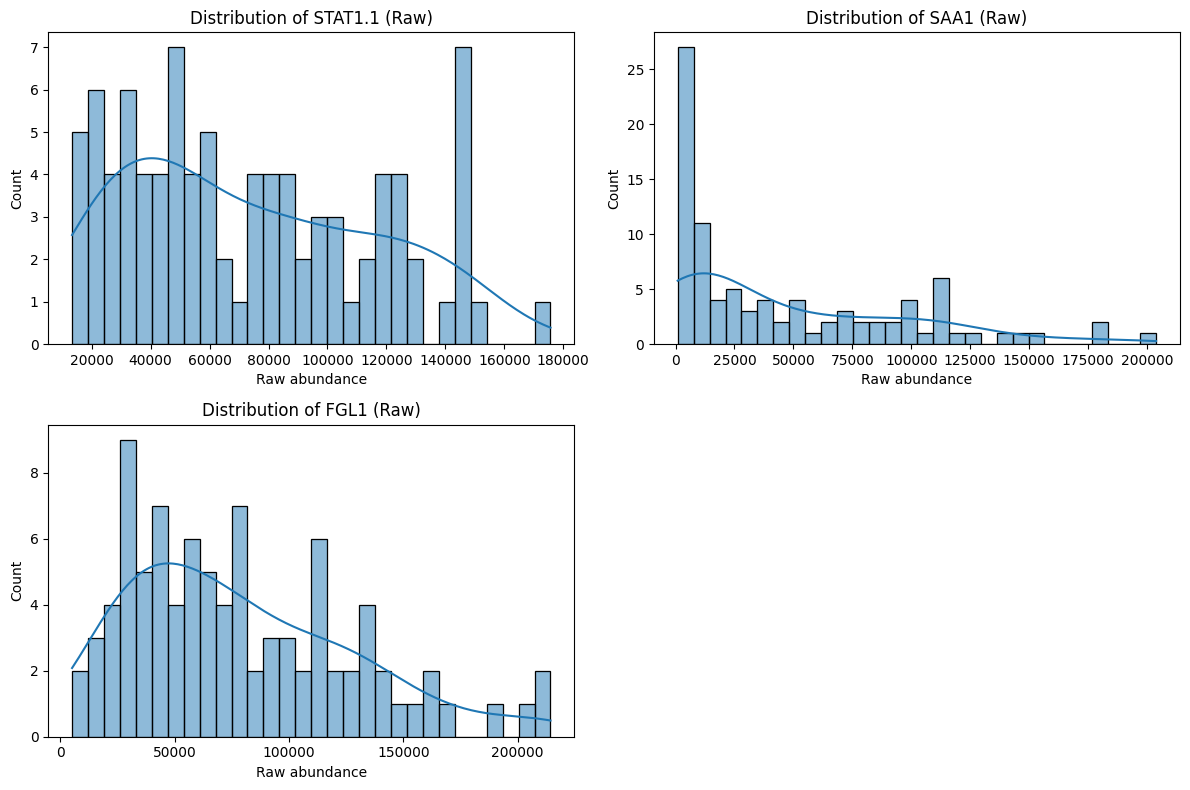

In [23]:
# ================================================================
# 7. LOG TRANSFORMATION OF PROTEINS (Proteomic data are right-skewed → log1p stabilizes variance)
# ================================================================

# ----------------------------
# 7.1 Check skewness visually: Histograms + KDE plots  
# ----------------------------
raw_proteins = ["STAT1.1", "SAA1", "FGL1"]

plt.figure(figsize=(12, 8))

for i, protein in enumerate(raw_proteins, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_patient[protein], kde=True, bins=30)
    plt.title(f"Distribution of {protein} (Raw)")
    plt.xlabel("Raw abundance")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [24]:
# ----------------------------
# 7.2 Apply Log1p transformation   
# ----------------------------
# List of proteins to transform
protein_cols = ["STAT1.1", "SAA1", "FGL1"]

# Apply log1p transformation (log(1 + x)) for each protein
for col in protein_cols:
    df_patient[f"log_{col}"] = np.log1p(df_patient[col])

print("\nPreview after log-transformation:")
print(df_patient[[f"log_{c}" for c in protein_cols]].head())


Preview after log-transformation:
   log_STAT1.1   log_SAA1   log_FGL1
0    11.888500  10.891819  11.189379
1    10.021048   8.798953  10.597025
2    10.306991   9.522878  10.629107
3     9.498432   8.787556  10.581996
4    11.718244  11.318236  11.623457


In [25]:
# ================================================================
# 8. STANDARDIZATION (Z-SCORES) (Required for regression models so proteins are comparable)
# ================================================================

scaler = StandardScaler()
df_patient[["z_STAT1.1", "z_SAA1", "z_FGL1"]] = scaler.fit_transform(
    df_patient[["log_STAT1.1", "log_SAA1", "log_FGL1"]]
)

print("\nPreview after standardization (z-scores):")
print(df_patient[["z_STAT1.1", "z_SAA1", "z_FGL1"]].head())


Preview after standardization (z-scores):
   z_STAT1.1    z_SAA1    z_FGL1
0   1.325698  0.628247  0.195229
1  -1.489976 -0.851560 -0.621020
2  -1.058843 -0.339693 -0.576812
3  -2.277957 -0.859619 -0.641730
4   1.068994  0.929755  0.793377


In [26]:
# ================================================================
# 9. SAVE FINAL CLEANED DATASET
# ================================================================
df_patient.to_csv("multivariate_patient_level_cleaned_with_neg.csv", index=False)

In [27]:
# ================================================================
# 10. MULTINOMIAL LOGISTIC REGRESSION ON PATIENT-LEVEL PROTEIN DATA
# ================================================================

# ----------------------------
# 10.1 Use patient-level dataset
# ----------------------------
df_mlr = df_patient.copy()

# Define severity labels
severity_map = {
    0: "Negative",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Critical"
}
df_mlr["severity_label"] = df_mlr["severity_num"].map(severity_map)

# Make it categorical in correct order
df_mlr["severity_label"] = pd.Categorical(
    df_mlr["severity_label"],
    categories=["Negative", "Mild", "Moderate", "Severe", "Critical"],
    ordered=False
)

# ----------------------------
# 10.2 Set predictors and outcome variable
# ----------------------------
X = add_constant(df_mlr[["z_STAT1.1", "z_SAA1", "z_FGL1", "sex_binary"]])
y = df_mlr["severity_label"]

# ----------------------------
# 10.3 Fit multinomial logistic regression
# ----------------------------
model = sm.MNLogit(y, X)
result = model.fit(maxiter=500)

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.853881
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:         severity_label   No. Observations:                   91
Model:                        MNLogit   Df Residuals:                       71
Method:                           MLE   Df Model:                           16
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.4258
Time:                        12:24:42   Log-Likelihood:                -77.703
converged:                       True   LL-Null:                       -135.32
Covariance Type:            nonrobust   LLR p-value:                 4.517e-17
    severity_label=Mild       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.4292      0.881      0.487      0.626      -1.298   

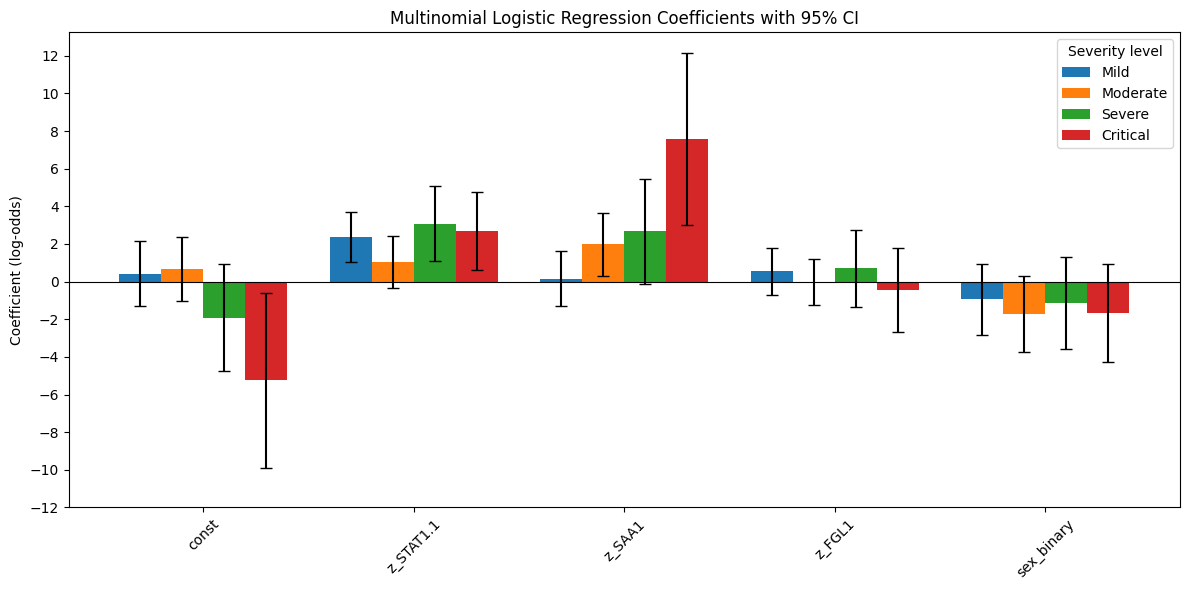

In [28]:
# ----------------------------
# 10.4 Visualize the multinomial logistic regression
# ----------------------------

# Extract coefficients and confidence intervals
coefs = result.params        
conf_int = result.conf_int() 

severity_map = {0: "Mild", 1: "Moderate", 2: "Severe", 3: "Critical"}
severity_names = [severity_map[c] for c in coefs.columns]

predictors = coefs.index

# Bar positioning
x = np.arange(len(predictors))
width = 0.2  

plt.figure(figsize=(12,6))

for i, severity in enumerate(coefs.columns):
    level_name = severity_map[severity]
    
    coef_vals = coefs[severity]
    ci_vals = conf_int.loc[level_name]
    
    lower_errors = coef_vals - ci_vals["lower"]
    upper_errors = ci_vals["upper"] - coef_vals
    yerr = [lower_errors.values, upper_errors.values]
    
    # Offset bars by i*width
    plt.bar(
        x + i*width,
        coef_vals.values,
        width=width,
        label=level_name,
        yerr=yerr,
        capsize=4
    )

# Formatting
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x + width * (len(severity_names) - 1) / 2, predictors, rotation=45)
plt.yticks(np.arange(-12, 14, 2))
plt.ylabel("Coefficient (log-odds)")
plt.title("Multinomial Logistic Regression Coefficients with 95% CI")
plt.legend(title="Severity level")
plt.tight_layout()
plt.show()

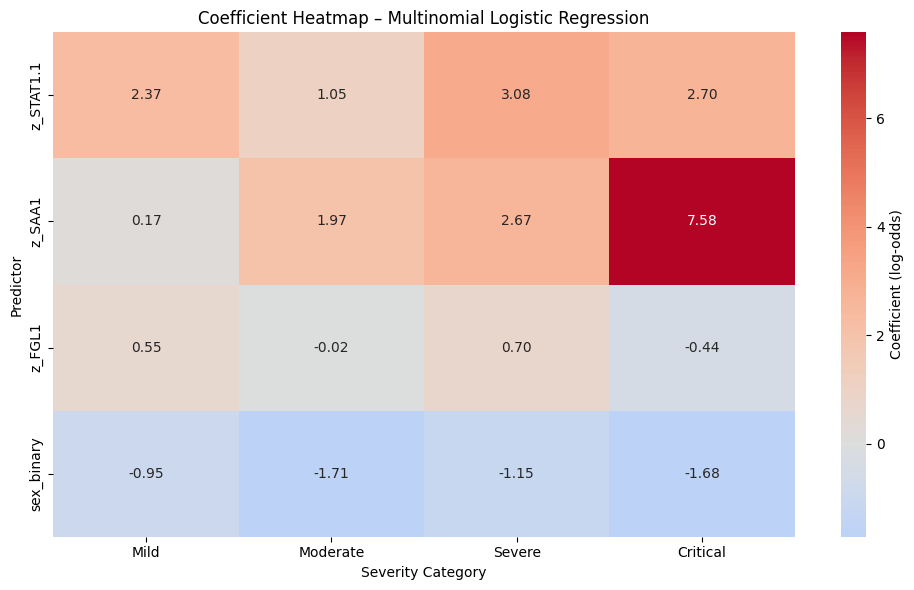

In [29]:
# ----------------------------
# 10.5 Visualize the multinomial logistic regression -> extra figure (heatmap)
# ----------------------------

# Extract coefficient matrix
coef = result.params.copy()

# Map numeric category names → severe class labels
severity_map = {
    0: "Mild",
    1: "Moderate",
    2: "Severe",
    3: "Critical"
}

# Rename the columns accordingly
coef = coef.rename(columns=severity_map)

# Remove intercepts
coef = coef.drop(index="const", errors="ignore")

plt.figure(figsize=(10, 6))
sns.heatmap(coef, annot=True, cmap="coolwarm", center=0, fmt=".2f", cbar_kws={"label": "Coefficient (log-odds)"})
plt.title("Coefficient Heatmap – Multinomial Logistic Regression")
plt.xlabel("Severity Category")
plt.ylabel("Predictor")
plt.tight_layout()
plt.show()